In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import baikalfunctions as bfunc
import scheme_mar2023 as scheme
import mysecure
pd.__version__, np.__version__

('1.5.3', '1.24.2')

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

%matplotlib inline
plt.style.use('dark_background')   # try another styles: 'classic'
plt.rcParams['figure.figsize'] = [15, 5]

In [4]:
obris = pd.read_csv("G:/1_Data1/obris/obris.dat",
                    header=0,
                    na_values='--',
                    sep='\t',
                    decimal=',',
                    )
obris.head(3)

,i,long,lat
0,1,NaN,NaN
1,2,109.004,53.667
2,3,109.008,53.665


In [5]:
pwd = 'G:\\1_Data1\\98_BaikalJul2024Sea\\'
saveImgPath = pwd
saveDataPath = pwd

In [6]:
df = pd.read_csv(pwd+'BaikalJul24Sea.dat',
                 sep='\t',
                 skiprows=[1],
                 parse_dates=['DateTime'],
                 dayfirst=True,
                 na_values='--',
                 decimal=',',
                )

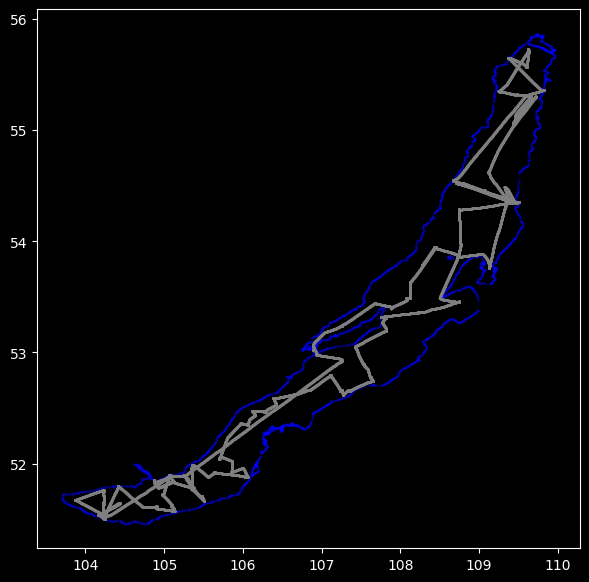

In [7]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.scatter('long', 'lat', data=obris, s=0.1, c='blue', alpha=0.5)
plt.scatter('Longitude', 'Latitude', data=df, s=0.2, c='grey')

(1.0, 10.0)

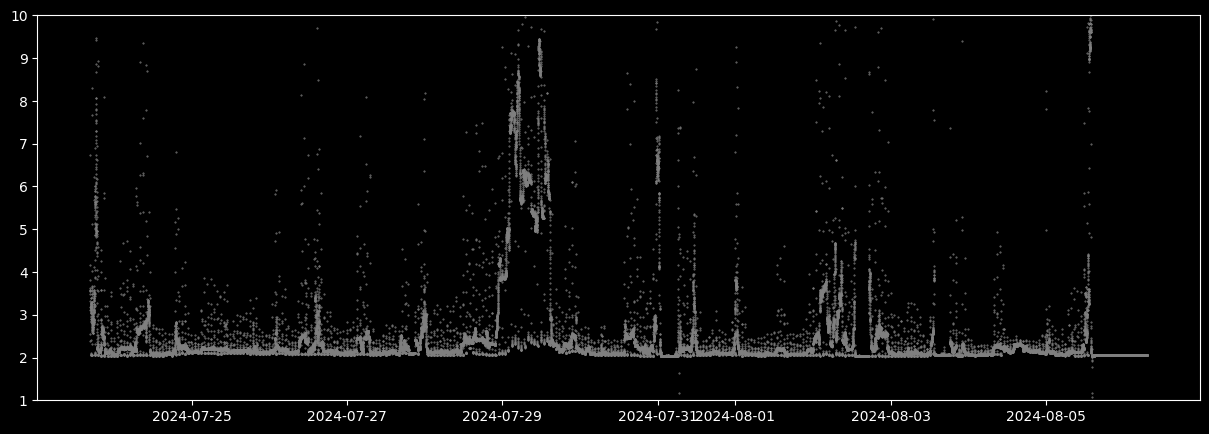

In [8]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.scatter('DateTime', 'vCH4', data=df, s=0.2, c='grey')
plt.ylim(1,10)

In [9]:
df['Channel'].fillna(0, inplace=True)
df['event'] = 0
df.loc[df['Channel'] != df['Channel'].shift(1), ['event']] = 1
df['event'] = df['event'].cumsum()

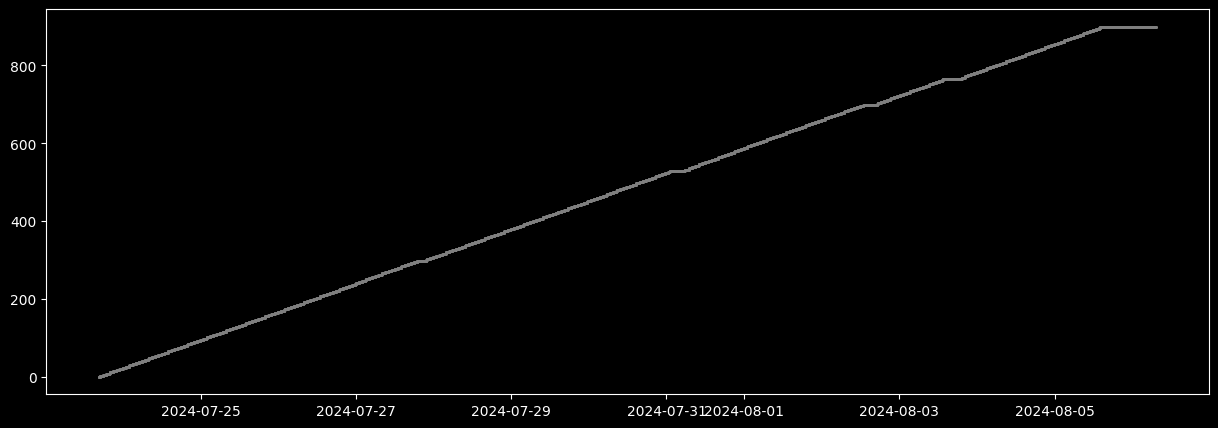

In [10]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.scatter('DateTime', 'event', data=df, s=0.2, c='grey')
#plt.xlim(pd.to_datetime('2024-07-31 05:30'), pd.to_datetime('2024-07-31 07:00'))
#plt.ylim(600, 850)

### Get adequate gas concentration in **air**   
reject last 5 points in each `event` (cycle, channel changing event). The most recent point is `invalid` too  

In [53]:
df['valid'] = 1
df.loc[(df['event'] != df['event'].shift(-2)), ['valid']] = 0
df.loc[(df['event'] != df['event'].shift(10)), ['valid']] = 0

df['vCO2air'] = df['vCO2'][(df['Channel'] == 6) & (df['valid'] != 0)]
df['vCH4air'] = df['vCH4'][(df['Channel'] == 6) & (df['valid'] != 0)]

In [58]:
df['inter'] = df['vCO2air'].interpolate()

(200.0, 500.0)

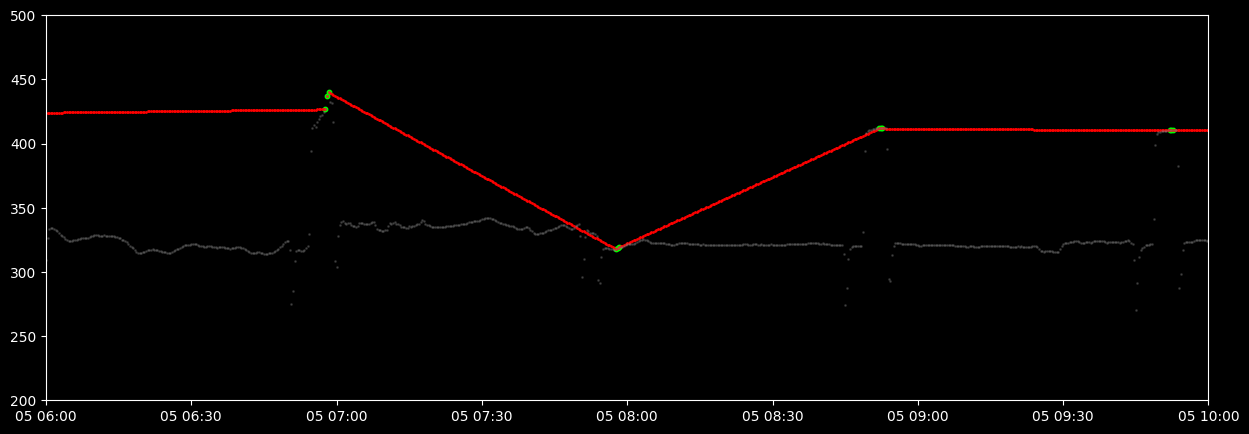

In [63]:
plt.scatter('DateTime', 'vCO2air', c='lime', s=10, data=df)
plt.scatter('DateTime', 'inter', c='red', s=1, data=df)
plt.scatter('DateTime', 'vCO2', c='grey', s=1, data=df, alpha=0.3)
plt.xlim(pd.to_datetime('2024-08-05 06:00'), pd.to_datetime('2024-08-05 10:00'))

plt.ylim(200, 500)

(1.0, 10.0)

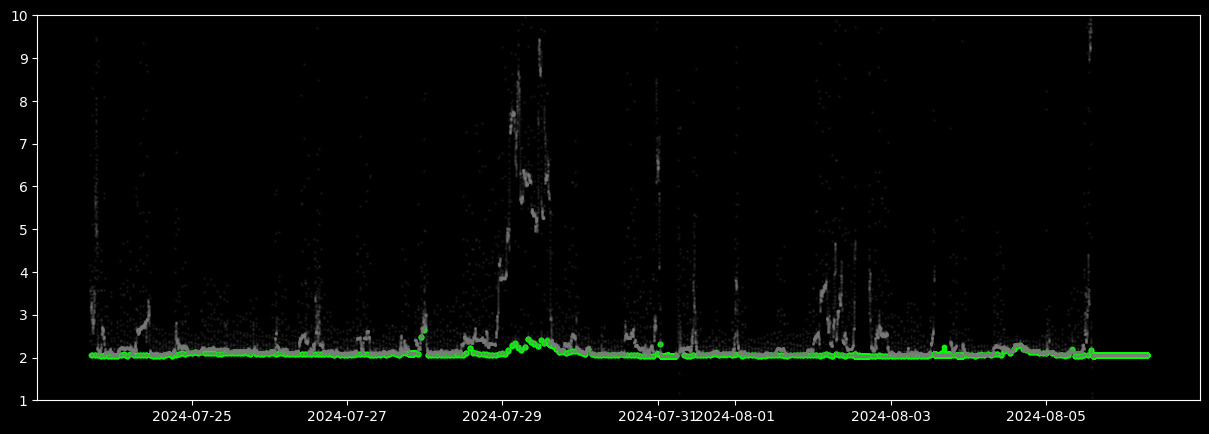

In [57]:
plt.scatter('DateTime', 'vCH4air', c='lime', s=10, data=df)
plt.scatter('DateTime', 'vCH4', c='grey', s=1, data=df, alpha=0.1)
#plt.xlim(pd.to_datetime('2024-07-27 00:00'), pd.to_datetime('2024-07-28 0:00'))

plt.ylim(1, 10)

## RECOVERY !!!
<i>be sure that:</i>
   - [ ] channel `1` is for equilibrator main channel;
   - [ ] channel `2` n `3` is for equilibrator refrence channels;
   - [ ] channel `6` is for atmosphere.

In [ ]:
equ_vol = scheme.equ_seatube_param['equ_vol']  # equivalent equ volume, l
equ_cap = scheme.equ_seatube_param['equ_cap']  # equilibrator capacity
wtr_flow_min = scheme.equ_seatube_param['water_flow_min'] 

In [ ]:
t_wtr = df['TempEqu1']
t_air = t_wtr
wtr_flow = df['WaterFlowEqu1']
air_flow = df['AirFlow']

In [ ]:
df.columns

In [ ]:
### CO2 water
df['vCO2equ'] = df['vCO2'][(df[chnl] == 1) & (df[ch_v] == 1) & (wtr_flow > wtr_flow_min)]
solubility = bfunc.getSolubility(t_wtr, 'CO2')

density = bfunc.getDensity(t_air, df['PressAir'], 'CO2')
cGasAir = df['pCO2air'] / 1000000 * density
pGasEquAir = df['vCO2equ'] * df['PressAir']
cGasEquAir = pGasEquAir * density / 1000000  # g/l

tau = equ_vol/(air_flow+wtr_flow*equ_cap*solubility/density)
eternal = (cGasEquAir-cGasEquAir.shift(1)*np.exp(-1*dt/tau))/(1-np.exp(-1*dt/tau))
cGasWtr = (eternal*(wtr_flow*equ_cap*solubility/density+air_flow)-air_flow*cGasAir)/(wtr_flow*equ_cap)

df['cCO2wtr'] = cGasWtr * 1000     # mg/l
df['pCO2wtr'] = cGasWtr * 1000000 / solubility  # mkatm

In [24]:
df['TempEqu2']

0        16.61
1        16.56
2        16.58
3        16.61
4        16.54
         ...  
58796    21.05
58797    21.05
58798    21.05
58799    21.05
58800    21.05
Name: TempEqu2, Length: 58801, dtype: float64

In [25]:
df['TempEqu2'].shift(1)

0          NaN
1        16.61
2        16.56
3        16.58
4        16.61
         ...  
58796    21.05
58797    21.05
58798    21.05
58799    21.05
58800    21.05
Name: TempEqu2, Length: 58801, dtype: float64